Utilizando la libreria de cv2 se divide la imagen de el contorno de la mascara en dos, para que utilizando la funcion cv2.goodFeaturesToTrack encuentre los puntos de interes, haciendo la distancia minima una una variable dinamica (tiene un fallo del 20% de las imagenes)

In [66]:
import pandas as pd
import cv2
from scipy.spatial import ConvexHull
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageDraw

In [67]:
def getLeftVertex(Topx, Topy, Leftx, Lefty):
    #express coordinates of the point (x2, y2) with respect to point (x1, y1)
    dx = Leftx - Topx
    dy = Lefty - Topy

    alpha = -70./180*math.pi  #60 Grades equal equilaterum Triangle (modified to 70 in order to have inclination into landmarkTop)

    #rotate the displacement vector and add the result back to the original point
    xp = Topx + math.cos( alpha)*dx + math.sin(alpha)*dy
    yp = Topy + math.sin(-alpha)*dx + math.cos(alpha)*dy

    return (xp, yp)

def getRightVertex(Topx, Topy, Rightx, Righty):
    #express coordinates of the point (x2, y2) with respect to point (x1, y1)
    dx = Rightx - Topx
    dy = Righty - Topy

    alpha = 30./180*math.pi  #60 Grades equal equilaterum Triangle (modified to 30 in order to have inclination into landmarkRight)

    #rotate the displacement vector and add the result back to the original point
    xp = Topx + math.cos( alpha)*dx + math.sin(alpha)*dy
    yp = Topy + math.sin(-alpha)*dx + math.cos(alpha)*dy

    return (xp, yp)

def getLeftCutArea(outlineImage, point1, point2, point3):   #Points = landmarkTop, landmarkLeft, leftVertex
    
    width, height = (112,112)#outlineImage.shape
    cutImage = Image.new("L", (width, height), "white")
    draw = ImageDraw.Draw(cutImage)

    # Draw lines passing through point1 and point3, and point2 and point3
    draw.line([point1, point3], fill="black", width=4)
    draw.line([point2, point3], fill="black", width=4)

    # Fill the area to the left of the lines with black color
    draw.polygon([point1, point3, (0, height), (0, 0)], fill="black")
    draw.polygon([point2, point3, (0, height), (0, 0)], fill="black")
    #imageRightFirst = Image.eval(imageRightFirst, lambda x: 255.0 - x)

    # Draw 3x3 white pixel squares with the given points as the center
    draw.rectangle([point1[0]-1, point1[1]-1, point1[0]+1, point1[1]+1], fill="black")
    draw.rectangle([point2[0]-1, point2[1]-1, point2[0]+1, point2[1]+1], fill="black")
    draw.rectangle([point3[0]-1, point3[1]-1, point3[0]+1, point3[1]+1], fill="black")

    return cutImage

def getRightCutArea(outlineImage, point1, point2, point3):   #Points = landmarkTop, landmarkRight, RightVertex
    
    width, height = (112,112) #outlineImage.shape
    cutImage = Image.new("L", (width, height), "white")
    draw = ImageDraw.Draw(cutImage)

    # Draw lines passing through point1 and point3, and point2 and point3
    draw.line([point1, point3], fill="black", width=4)
    draw.line([point2, point3], fill="black", width=4)

    # Fill the area to the right of the lines with black color
    draw.polygon([point1, point3, (width, height), (width, 0)], fill="black")
    draw.polygon([point2, point3, (width, height), (width, 0)], fill="black")
    #imageRightFirst = Image.eval(imageRightFirst, lambda x: 255.0 - x)

    # Draw 3x3 white pixel squares with the given points as the center
    draw.rectangle([point1[0]-1, point1[1]-1, point1[0]+1, point1[1]+1], fill="black")
    draw.rectangle([point2[0]-1, point2[1]-1, point2[0]+1, point2[1]+1], fill="black")
    draw.rectangle([point3[0]-1, point3[1]-1, point3[0]+1, point3[1]+1], fill="black")

    return cutImage

def multiply_images(outlineImage, cutArea):
    # Open the images
    img1 = outlineImage
    img2 = cutArea

    # Ensure both images have the same size
    #if img1.size != img2.size:
    #    raise ValueError("Images must have the same size")

    # Get the pixel data for both images
    pixels1 = list(img1.getdata())
    pixels2 = list(img2.getdata())

    # Multiply corresponding pixel values
    multiplied_pixels = [p1 * p2 // 255 for p1, p2 in zip(pixels1, pixels2)]

    # Create a new image with the multiplied pixel values
    result_image = Image.new("L", img1.size)
    result_image.putdata(multiplied_pixels)

    # Show the result image
    #plt.imshow(result_image)
    #plt.show()
    return result_image

def getLargestComponent(cutArea):

    # Conver PIL image into Numpy array
    cutArea = np.array(cutArea)
    # Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cutArea, connectivity=8)

    # Find the largest connected component (excluding the background)
    largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1  # +1 to skip the background label

    # Create a new image with only the largest component
    largest_component_image = np.zeros_like(cutArea)
    largest_component_image[labels == largest_component_label] = 255   

    return largest_component_image 

def getLandmarks(lineArray, pointTop, pointBot, mode):

    realYDiff = pointBot - pointTop
    minDistanceReal = realYDiff*0.8 # 20% of difference, can be changed
    corners = cv2.goodFeaturesToTrack(lineArray, maxCorners=2, qualityLevel=0.01, minDistance=minDistanceReal)
    # Extract the second item in each sub-array
    outlineYs = corners[:, :, 1]

    # Calculate the maximum and minimum values
    max_value = np.max(outlineYs)
    min_value = np.min(outlineYs)

    # Calculate the difference
    minDistanceOutline = max_value - min_value
    #Formula = ((max(y) - min(y))/4) + 2
    minDistanceFinal = (minDistanceOutline/4) + 2
    corners = cv2.goodFeaturesToTrack(lineArray, maxCorners=4, qualityLevel=0.01, minDistance=minDistanceOutline/4)
    # Get the indices that would sort the array along the second axis
    sorted_indices = np.argsort(corners[:, :, 1], axis=0)
    sorted_points = corners[sorted_indices]
    
    if mode == 'left':
        landmark0 = (sorted_points[1][0][0][0], sorted_points[1][0][0][1])
        landmark1 = (sorted_points[2][0][0][0], sorted_points[2][0][0][1])
    else:
        landmark0 = (sorted_points[2][0][0][0], sorted_points[2][0][0][1])
        landmark1 = (sorted_points[1][0][0][0], sorted_points[1][0][0][1])
    
    #landmarks.append(sorted_points[2])
    return landmark0, landmark1

def threePoint2Seven(outlineMaskPath, landmarkTop, landmarkLeft, landmarkRight):

    finalPointArray = []
    outlineImage = Image.open(outlineMaskPath).convert("L")

    finalPointArray.append(landmarkTop)

    leftVertex = getLeftVertex(landmarkTop[0],landmarkTop[1],landmarkLeft[0],landmarkLeft[1])
    rightVertex = getRightVertex(landmarkTop[0],landmarkTop[1],landmarkRight[0],landmarkRight[1])    
    
    leftCutArea = getLeftCutArea(outlineImage, landmarkTop, landmarkLeft, leftVertex)
    rightCutArea = getRightCutArea(outlineImage, landmarkTop, landmarkRight, rightVertex)
    
    leftCuttedArea = multiply_images(outlineImage, leftCutArea)
    rightCuttedArea = multiply_images(outlineImage, rightCutArea)

    leftLine = getLargestComponent(leftCuttedArea)
    rightLine = getLargestComponent(rightCuttedArea)
    
    landmark2, landmark3 = getLandmarks(leftLine, landmarkTop[1], landmarkLeft[1],'left')
    finalPointArray.append(landmark2)
    finalPointArray.append(landmark3)
    finalPointArray.append(landmarkLeft)

    landmark6, landmark7 = getLandmarks(rightLine, landmarkTop[1], landmarkRight[1],'right')
    finalPointArray.append(landmarkRight)
    finalPointArray.append(landmark6)
    finalPointArray.append(landmark7)
    

    return finalPointArray

In [68]:
data_path = '/home/alanr/Documents/Corazon/Data/'

In [69]:
volumeTracings = pd.read_csv(data_path + 'VolumeTracings.csv')
volumeTracings 

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46
...,...,...,...,...,...,...
425005,0XFEBEEFF93F6FEB9.avi,45.419984,55.131136,69.758942,57.498739,38
425006,0XFEBEEFF93F6FEB9.avi,45.017994,57.543075,69.399107,59.914779,38
425007,0XFEBEEFF93F6FEB9.avi,44.616005,59.955014,69.039271,62.330818,38
425008,0XFEBEEFF93F6FEB9.avi,44.214015,62.366952,68.712853,64.750108,38


In [70]:
fileList = pd.read_csv(data_path + 'FileList.csv')
fileList = fileList.head(50)


In [71]:
directory = volumeTracings.groupby(['FileName', 'Frame']).size().reset_index(name='Count')
directory.head()

,FileName,Frame,Count
0,0X100009310A3BD7FC.avi,46,21
1,0X100009310A3BD7FC.avi,61,21
2,0X1002E8FBACD08477.avi,3,21
3,0X1002E8FBACD08477.avi,18,21
4,0X1005D03EED19C65B.avi,24,21


In [72]:
directory.drop([10670, 10671], inplace=True)

Point with the lowest Y1: (51.26041667, 15.34895833)
Top, Left Right (51.26041667, 15.34895833) (79.33392349, 67.02362953) (57.51297555, 69.55532799)
nxt
INDEX: 0  IMAGE: 0X100009310A3BD7FC.avi  FRAME: 46  SPLIT: VAL
Point with the lowest Y1: (56.0, 19.54166667)
Top, Left Right (56.0, 19.54166667) (70.31174597, 60.71738172) (53.42533373, 62.92615295)
nxt
INDEX: 1  IMAGE: 0X100009310A3BD7FC.avi  FRAME: 61  SPLIT: VAL
Point with the lowest Y1: (48.16145833, 20.63541667)
Top, Left Right (48.16145833, 20.63541667) (81.38109138, 67.81975569) (57.75855232, 70.9776363)
nxt


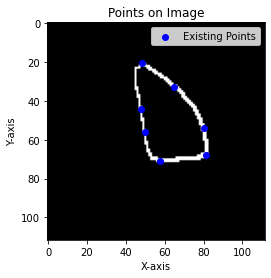

INDEX: 2  IMAGE: 0X1002E8FBACD08477.avi  FRAME: 3  SPLIT: TRAIN
Point with the lowest Y1: (52.53645833, 27.015625)
Top, Left Right (52.53645833, 27.015625) (76.99164294, 60.75326736) (61.22699079, 65.64355571)
nxt


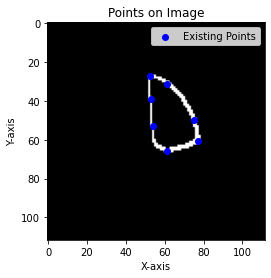

INDEX: 3  IMAGE: 0X1002E8FBACD08477.avi  FRAME: 18  SPLIT: TRAIN
Point with the lowest Y1: (65.84375, 20.27083333)
Top, Left Right (65.84375, 20.27083333) (91.65138166, 59.5912926) (75.10920436, 65.36020318)
nxt


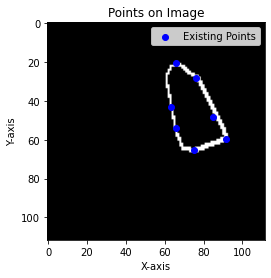

INDEX: 4  IMAGE: 0X1005D03EED19C65B.avi  FRAME: 24  SPLIT: TRAIN
Point with the lowest Y1: (64.56770833, 24.828125)
Top, Left Right (64.56770833, 24.828125) (85.77645034, 55.66505677) (68.56589593, 60.15144374)
nxt


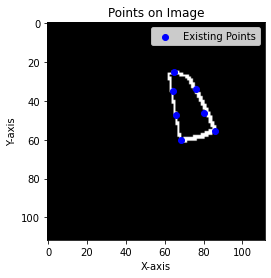

INDEX: 5  IMAGE: 0X1005D03EED19C65B.avi  FRAME: 35  SPLIT: TRAIN
Point with the lowest Y1: (57.640625, 24.09895833)
Top, Left Right (57.640625, 24.09895833) (78.22183898, 70.54299645) (53.76999628, 74.61830357)
nxt


IndexError: index 2 is out of bounds for axis 0 with size 2

In [73]:
#Be sure to have the output directories already created

for index, series in directory.iterrows():

  # Open ECG image
  input_path = f'{data_path}Videos/{series[0]}'
  cap = cv2.VideoCapture(input_path)
  cap.set(cv2.CAP_PROP_POS_FRAMES, series[1])
  ret, frame = cap.read()

  # Use Convex Hull to create polygon
  points = volumeTracings[(volumeTracings['FileName'] == series[0]) & (volumeTracings['Frame'] == series[1])]
  
###########################################################################
  # Assuming your dataset is stored in a pandas DataFrame called 'df'
  # If not, you can create a DataFrame using pd.DataFrame(your_data)
  points = pd.DataFrame(points)
  # Find the row with the minimum Y1
  min_Y1_row = points.loc[points['Y1'].idxmin()]
  min_Y1_index = points['Y1'].idxmin()
  min_Y1_value = min_Y1_row['Y1']
  
  # Find the row with the minimum Y2
  min_Y2_row = points.loc[points['Y2'].idxmin()]
  min_Y2_index = points['Y2'].idxmin()
  min_Y2_value = min_Y1_row['Y2']

  if min_Y1_value < min_Y2_value:
    landmarkTop = (min_Y1_row['X1'], min_Y1_row['Y1'])
    points = points.drop(index=min_Y1_index).reset_index(drop=True)
    print("Point with the lowest Y1:", landmarkTop)
  else:
    landmarkTop = (min_Y2_row['X2'], min_Y2_row['Y2'])
    points = points.drop(index=min_Y2_index).reset_index(drop=True)
    print("Point with the lowest Y2:", landmarkTop)
  # Extract the relevant information as tuples

  min_Y2_row = points.loc[points['Y2'].idxmax()]
  landmarkLeft = (min_Y2_row['X2'], min_Y2_row['Y2'])

  min_Y1_row = points.loc[points['Y1'].idxmax()]
  landmarkRight = (min_Y1_row['X1'], min_Y1_row['Y1'])

  
  

  # Print or use the result as needed
  print("Top, Left Right", landmarkTop, landmarkLeft, landmarkRight)


#############################################################################
  points = pd.DataFrame({'X': pd.concat([points.X1, points.X2], ignore_index=True), 'Y': pd.concat([points.Y1, points.Y2], ignore_index=True)})
  
  print('nxt')
  points = points.iloc[ConvexHull(points[['X', 'Y']].values).vertices]

  # Create Mask Image
  h, w, c = frame.shape
  background = np.zeros((h, w, c), dtype=np.uint8)
  mask = np.array(points.values, np.int32).reshape((-1, 1, 2))
  color = (255, 255, 255)
  image = cv2.fillPoly(background, [mask], color)

  #Erode image 
  kernelErode = np.ones((3, 3), np.uint8)
  erode_mask = cv2.erode(image, kernelErode, iterations=1)

  #Dilate image s
  kernel = np.ones((2, 2), np.uint8)  # Adjust the kernel size as needed
  dilated_mask = cv2.dilate(image, kernel, iterations=1)

  image = dilated_mask - erode_mask

  # Save both images
  split = fileList.loc[fileList['FileName'] == series[0][:-4], 'Split'].iloc[0]
  if split == 'TRAIN':
    cv2.imwrite(f'{data_path}train/image/{series[0][:-4]}_{series[1]}.png', frame)
    cv2.imwrite(f'{data_path}train/mask/{series[0][:-4]}_{series[1]}.png', image)
    a = threePoint2Seven(f'{data_path}train/mask/{series[0][:-4]}_{series[1]}.png',landmarkTop,landmarkLeft,landmarkRight)
    # Coordinates of the existing points on the image
    existing_points = a
    image = cv2.imread(f'{data_path}train/mask/{series[0][:-4]}_{series[1]}.png', 0)
    plt.imshow(image, cmap='gray')
    # Plot the existing points
    existing_x, existing_y = zip(*existing_points)
    plt.scatter(existing_x, existing_y, color='blue', label='Existing Points')


    # Show the image
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Points on Image')
    plt.legend()
    plt.show()
        
  if split == 'VAL':
    cv2.imwrite(f'{data_path}val/image/{series[0][:-4]}_{series[1]}.png', frame)
    cv2.imwrite(f'{data_path}val/mask/{series[0][:-4]}_{series[1]}.png', image)
  if split == 'TEST':
    cv2.imwrite(f'{data_path}test/image/{series[0][:-4]}_{series[1]}.png', frame)
    cv2.imwrite(f'{data_path}test/mask/{series[0][:-4]}_{series[1]}.png', image)

  # Close image
  cap.release()
  print(f'INDEX: {index}  IMAGE: {series[0]}  FRAME: {series[1]}  SPLIT: {split}') 

In [ ]:

paths = [f'{data_path}train/image',
         f'{data_path}train/mask',
         f'{data_path}val/image',
         f'{data_path}val/mask',
         f'{data_path}test/image',
         f'{data_path}test/mask']
c = 0

for path in paths:
  files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
  num_files = len(files)
  print(f'{path}: {num_files}')
  c += num_files

print(f'{c} files ({c/2} files)')

/home/alanr/Documents/Corazon/Data/train/image: 82
/home/alanr/Documents/Corazon/Data/train/mask: 82
/home/alanr/Documents/Corazon/Data/val/image: 10
/home/alanr/Documents/Corazon/Data/val/mask: 10
/home/alanr/Documents/Corazon/Data/test/image: 8
/home/alanr/Documents/Corazon/Data/test/mask: 8
200 files (100.0 files)
